## Upload to S3
Example code of how to upload a particular director to s3. In this case we are uploading anthing that does not already exist to s3 in the train_models folder.

In [ ]:
import sys, os
sys.path.append("/b2p")
from bin.sync_composites_to_s3 import * 
from tqdm.auto import tqdm

In [ ]:
s3 = initialize_s3_bucket(CONFIG.AWS.BUCKET)
for root, dirs, files in os.walk('data/trained_models'):
    for f in files:
        filename = os.path.join(root, f)
        file_size = os.stat(filename).st_size
        key = os.path.join(root, os.path.basename(filename))
        key = '/'.join(key.split('/')[1:])
        if len(list(s3.objects.filter(Prefix=key))) == 0: # if the file does not already exist on s3
            with tqdm(total=file_size, unit='B', unit_scale=True, desc=filename, leave=False, position=1) as pbar:
                s3.upload_file(
                    Filename=filename,
                    Key=key,
                    Callback=lambda bytes_transferred: pbar.update(bytes_transferred),
                )

## Download From S3
Example code of how to download pretrained models from s3

In [ ]:
import sys, os
sys.path.append("/b2p")
from bin.sync_composites_to_s3 import * 
from tqdm.auto import tqdm

In [ ]:
s3 = initialize_s3_bucket(CONFIG.AWS.BUCKET)
ll = list( s3.objects.filter(Prefix='trained_models'))
for obj in tqdm(ll, desc="Dowloading models...",position=0):
    pth = os.path.join('data', obj.key)
    base_dir,_ = os.path.split(pth)
    if ".tar" not in pth: 
        continue
    os.makedirs(base_dir, exist_ok=True)
    with tqdm(total=int(obj.size), unit='B', unit_scale=True, desc=pth, leave=False, position=1) as pbar:
        s3.download_file(
            Key=obj.key, 
            Filename=pth,
            Callback=lambda bytes_transferred: pbar.update(bytes_transferred)
        )

# Run Inference 
This is an example of how to run inference from the notebook. Sometimes this is not a good idea because it can take hours for large areas. 

In [ ]:
import sys, os
from glob import glob
from tqdm.auto import tqdm
sys.path.append("/b2p")
from bin.run_inference import *

In [ ]:
best_optical_model = 'data/trained_models/optical_5.25.2023/resnet34/ratio_1.0/resnet34.red_blue_green.best_tp.tar'
optical_res_csv = 'data/trained_models/optical_5.25.2023/metrics/all.resnet34.red_blue_green.best_tp.ratio_1.0.csv'
all_tiles_csv = 'data/tiles/multivariate_tile_match.csv'
if os.path.isfile(optical_res_csv): os.remove(optical_res_csv)
run_inference(
    best_optical_model,
    all_tiles_csv,
    optical_res_csv,
    True, # truth data
    batch_size = CONFIG.TORCH.INFERENCE.BATCH_SIZE,
    num_workers = CONFIG.TORCH.INFERENCE.NUM_WORKERS)

In [ ]:
best_multi_model = 'data/trained_models/multivariate_5.18.2023/resnet18/ratio_2.0/resnet18.nir_osm-water_elevation.best.tar'
multi_res_csv = 'data/trained_models/multivariate_5.18.2023/metrics/all.resnet18.nir_osm-water_elevation.best.ratio_2.0.csv'
all_tiles_csv = 'data/tiles/multivariate_tile_match.csv'
run_inference(
    best_multi_model,
    all_tiles_csv,
    multi_res_csv,
    True, # truth data
    batch_size = CONFIG.TORCH.INFERENCE.BATCH_SIZE,
    num_workers = CONFIG.TORCH.INFERENCE.NUM_WORKERS)

# Accuracy Box Plots
Create box plots for all models 

In [ ]:
import sys, os
from glob import glob 
from tqdm.auto import tqdm
sys.path.append("/b2p")
from src.utilities.plotting import *

In [ ]:
plt_dir = 'data/trained_models'
for model in glob(os.path.join(plt_dir, "**/resnet*"), recursive=True):
    if os.path.isfile(model):
        continue
    top_lvl, resnet = os.path.split(model)
    _, tp = os.path.split(top_lvl)
    metrics_dir = os.path.join(top_lvl, 'metrics')
    os.makedirs(metrics_dir, exist_ok=True)
    for acc in ['total_acc', 'bridge_acc', 'no_bridge_acc']:
        ratio_box_plot(
            model, 
            acc, 
            os.path.join(metrics_dir, f'{tp}_{resnet}_{acc}.png')
    )

## Get Best TP Model
I want to isolate the models that give us the best true positive accuracy as well. The training script isolates which model out of all epochs gives the best total accuracy. Here we isolate the best true positive accuracy.

In [ ]:
import sys, os, shutil
from glob import glob 
from tqdm.auto import tqdm
sys.path.append("/b2p")
from src.utilities.plotting import *

In [ ]:
acc_key = 'bridge_acc'
for file in glob(os.path.join("data/trained_models/**/accuracy_summary.json"), recursive=True):
    with open(file, 'r') as f: 
        plotting_data = fixJSONKeys(json.load(f))
    for ratio in plotting_data["ratios"]:
        accuracies = [plotting_data[ratio][epoch][acc_key] for epoch in sorted(plotting_data[ratio].keys())]
        fn = [plotting_data[ratio][epoch]['file'] for epoch in sorted(plotting_data[ratio].keys())]
        ix = np.argsort(accuracies)
        best_ix = ix[-1]
        dir, ff = os.path.split(fn[-1])
        prts = ff.split('.')
        ff = os.path.join(dir, '.'.join(prts[:-2])+".best_tp.tar")
        print(fn[-1])
        print(ff)
        shutil.copy(fn[-1], ff)


In [ ]:
for ff in tqdm(glob(os.path.join('data/trained_models/**/*chkpt*'), recursive=True)):
    os.remove(ff)

## Comparing ROC Curves Across models 
In the process of model selection, First we trained three seperate sets of models. One set that included  we ran a wide sweep of potential parameterizations using the scrip `validation_model_sweep.py`. 

In [1]:
import sys, os
from tqdm.auto import tqdm
from glob import glob
sys.path.append("/b2p")
from src.ml.metrics import * 

/home/ec2-user/anaconda3/envs/b2p/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


100%|██████████| 54/54 [09:59<00:00, 11.11s/it]


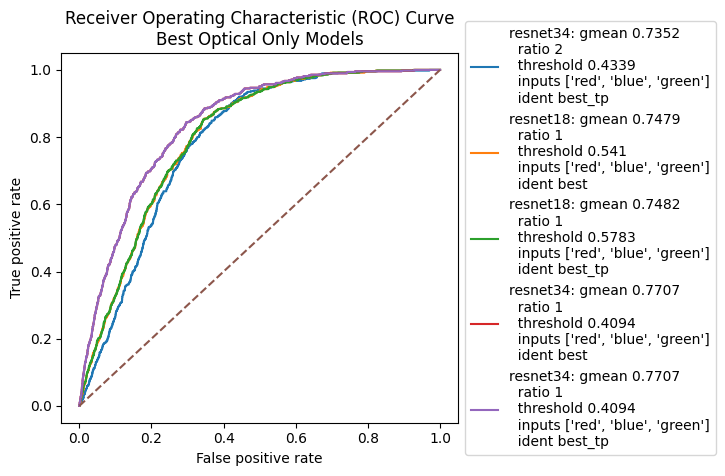

In [2]:
metrics = []
for res_csv in tqdm(glob('data/trained_models/**/metrics/validation.*csv')):
    prts = os.path.basename(res_csv).split('.')
    model, inputs, ident, ratio = prts[1:5] 
    inputs = inputs.split('_')
    _, ratio = ratio.split('_')
    
    metrics.append( 
        (
            (model, inputs, ident, ratio),
            Metrics(
                res_csv,
                'data/tiles/val_df.csv'
            )
        )
    )
fpr, tpr, thresholds = [], [], []
for _, metric in tqdm(metrics):
    this_fpr, this_tpr, this_thresh = metric._get_fpr_trp_thresh()
    fpr.append(this_fpr)
    tpr.append(this_tpr)
    thresholds.append(this_thresh)
gmeanOpt = []
threshOpt = []
for ((model, inputs, ident, ratio), _), this_fpr, this_tpr, this_thresh in zip(metrics, fpr, tpr, thresholds):
    if 'red' not in inputs: # look for optical only models only 
        gmeanOpt.append(-1)
        threshOpt.append(-1)
        continue
    gmean = np.sqrt(this_tpr * (1 - this_fpr))
    # Find the optimal threshold
    index = np.argmax(gmean)
    gmeanOpt.append(round(gmean[index], ndigits=4))
    threshOpt.append(round(this_thresh[index], ndigits=4))
IX = np.argsort(gmeanOpt)
outpath = "data/trained_models/best_optical_only_roc.png"
plt.figure()
ax = plt.subplot(111)
N = 5
for ix in IX[-N:]:
    ((model, inputs, ident, ratio), _) = metrics[ix] 
    this_gmean = gmeanOpt[ix] 
    this_fpr = fpr[ix]
    this_tpr = tpr[ix]
    this_thresh = threshOpt[ix]
    plt.plot(this_fpr, this_tpr, label=f'{model}: gmean {this_gmean}\n  ratio {ratio}\n  threshold {this_thresh}\n  inputs {inputs}\n  ident {ident}')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.title(
    'Receiver Operating Characteristic (ROC) Curve\n'
    'Best Optical Only Models'
)
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.ylabel('True positive rate')
plt.xlabel('False positive rate')
plt.savefig(outpath, bbox_inches='tight')
plt.show()

Best Threshold: 0.4094 with G-Mean: 0.7707
FPR: 0.297, TPR: 0.8449
Precision: 0.0014402877283370438, F1 score: 0.7157260020140513, Total Accuracy: 0.7916363442882938


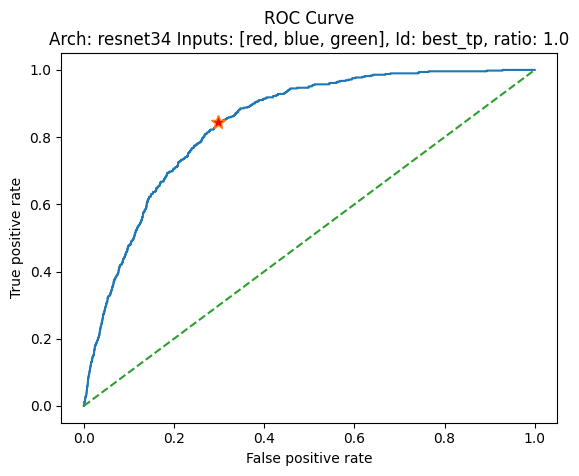

In [12]:
_, metric_optical = metrics[IX[-1]]
metric_optical.plot_roc(outpath='data/trained_models/optical_5.25.2023/metrics/roc.resnet34.red_blue_green.best_tp.ratio_1.0.png', titleStr='ROC Curve\nArch: resnet34 Inputs: [red, blue, green], Id: best_tp, ratio: 1.0')
None


100%|██████████| 54/54 [10:12<00:00, 11.35s/it]


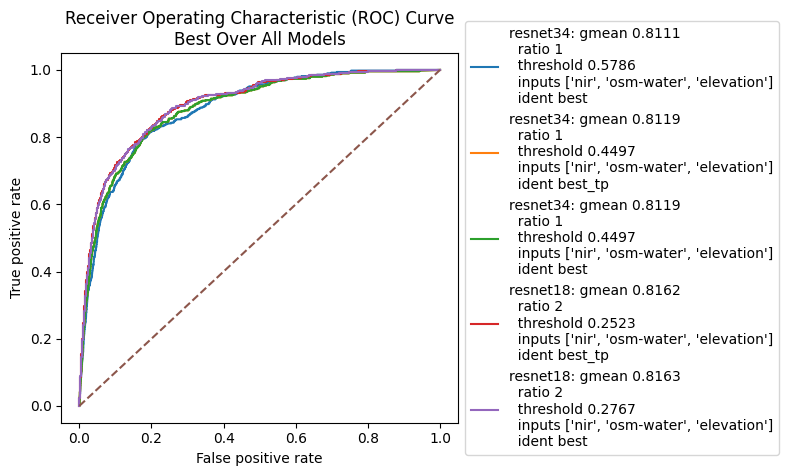

In [2]:
metrics = []
for res_csv in tqdm(glob('data/trained_models/**/metrics/validation.*csv')):
    prts = os.path.basename(res_csv).split('.')
    model, inputs, ident, ratio = prts[1:5] 
    inputs = inputs.split('_')
    _, ratio = ratio.split('_')
    
    metrics.append( 
        (
            (model, inputs, ident, ratio),
            Metrics(
                res_csv,
                'data/tiles/val_df.csv'
            )
        )
    )
fpr, tpr, thresholds = [], [], []
for _, metric in tqdm(metrics):
    this_fpr, this_tpr, this_thresh = metric._get_fpr_trp_thresh()
    fpr.append(this_fpr)
    tpr.append(this_tpr)
    thresholds.append(this_thresh)
gmeanOpt = []
threshOpt = []
for ((model, inputs, ident, ratio), _), this_fpr, this_tpr, this_thresh in zip(metrics, fpr, tpr, thresholds):
    gmean = np.sqrt(this_tpr * (1 - this_fpr))
    # Find the optimal threshold
    index = np.argmax(gmean)
    gmeanOpt.append(round(gmean[index], ndigits=4))
    threshOpt.append(round(this_thresh[index], ndigits=4))
IX = np.argsort(gmeanOpt)
outpath = "data/trained_models/best_roc.png"
plt.figure()
ax = plt.subplot(111)
N = 5
for ix in IX[-N:]:
    ((model, inputs, ident, ratio), _) = metrics[ix] 
    this_gmean = gmeanOpt[ix] 
    this_fpr = fpr[ix]
    this_tpr = tpr[ix]
    this_thresh = threshOpt[ix]
    plt.plot(this_fpr, this_tpr, label=f'{model}: gmean {this_gmean}\n  ratio {ratio}\n  threshold {this_thresh}\n  inputs {inputs}\n  ident {ident}')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.title(
    'Receiver Operating Characteristic (ROC) Curve\n'
    'Best Over All Models'
)
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.ylabel('True positive rate')
plt.xlabel('False positive rate')
plt.savefig(outpath, bbox_inches='tight')
plt.show()


Best Threshold: 0.2767 with G-Mean: 0.8163
FPR: 0.1838, TPR: 0.8163
Precision: 0.00391537961111245, F1 score: 0.6671806857335614, Total Accuracy: 0.9289031766410127


(array([0.00000000e+00, 8.58541544e-07, 1.54537478e-05, 1.54537478e-05,
        1.71708309e-05, 1.71708309e-05, 2.23220801e-05, 2.23220801e-05,
        5.40881173e-05, 5.40881173e-05, 1.21054358e-04, 1.21054358e-04,
        1.27064149e-04, 1.27064149e-04, 2.50694131e-04, 2.50694131e-04,
        3.15943288e-04, 3.15943288e-04, 3.76899738e-04, 3.76899738e-04,
        3.79475362e-04, 3.79475362e-04, 4.33563480e-04, 4.33563480e-04,
        5.80374084e-04, 5.80374084e-04, 5.99261998e-04, 5.99261998e-04,
        8.00160719e-04, 8.00160719e-04, 8.59400086e-04, 8.59400086e-04,
        9.87322776e-04, 9.87322776e-04, 1.19594837e-03, 1.19594837e-03,
        1.24488524e-03, 1.24488524e-03, 1.25432920e-03, 1.25432920e-03,
        1.42088626e-03, 1.42088626e-03, 1.43719854e-03, 1.43719854e-03,
        1.49643791e-03, 1.49643791e-03, 1.51618437e-03, 1.51618437e-03,
        1.54279915e-03, 1.54279915e-03, 1.57113103e-03, 1.57113103e-03,
        1.60547269e-03, 1.60547269e-03, 1.65355101e-03, 1.653551

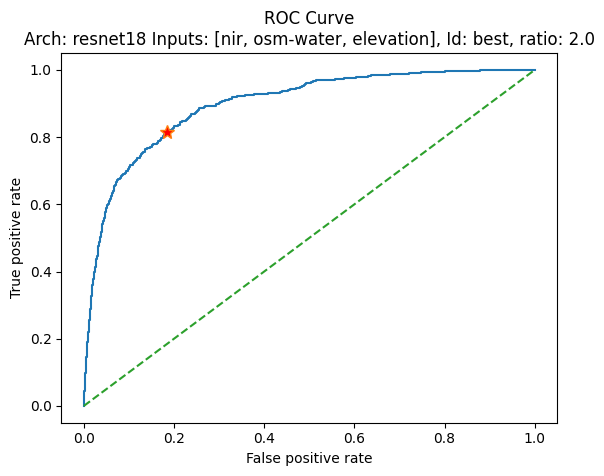

In [3]:
_, metric_multi = metrics[IX[-1]]
metric_multi.plot_roc(outpath='data/trained_models/multivariate_5.18.2023/metrics/roc.resnet18.nir_osm-water_elevation.best.ratio_2.0.png', titleStr='ROC Curve\nArch: resnet18 Inputs: [nir, osm-water, elevation], Id: best, ratio: 2.0')

# Convert results csv to shp file 

In [ ]:
import sys, os
from tqdm.auto import tqdm
from glob import glob
sys.path.append("/b2p")
from src.utilities.files import results_csv_to_shapefile



In [ ]:
import geopandas, pandas
from shapely.geometry.polygon import Polygon
def csv_to_shp(csv_input,shp_output):
    gdf = geopandas.GeoDataFrame(pandas.read_csv(csv_input))
    bbox = [Polygon(eval(bbox)) for bbox in gdf['bbox']]
    gdf.set_geometry(
        bbox,
        inplace=True, 
        crs='EPSG:4326'
    )
    gdf.drop(['tile', 'bbox', 'Unnamed: 0'], axis=1, inplace=True)
    gdf.to_file(shp_output)


In [ ]:
csv_input = 'data/trained_models/multivariate_5.18.2023/metrics/all.resnet18.nir_osm-water_elevation.best.ratio_2.0.csv'
shp_output ='data/trained_models/multivariate_5.18.2023/metrics/all.resnet18.nir_osm-water_elevation.best.ratio_2.0.shp'
csv_to_shp(csv_input, shp_output)

In [ ]:
csv_input = 'data/trained_models/optical_5.25.2023/metrics/all.resnet34.red_blue_green.best_tp.ratio_1.0.csv'
shp_output ='data/trained_models/optical_5.25.2023/metrics/all.resnet34.red_blue_green.best_tp.ratio_1.0.shp'
csv_to_shp(csv_input, shp_output)